## Imports

In [1]:
from datasets import Dataset, DatasetDict, load_metric
import numpy as np
import matplotlib.pyplot as plt
from transformers import MarianMTModel, MarianTokenizer
import torch
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import nltk
from nltk.translate.bleu_score import corpus_bleu

## Load raw dataset

In [2]:
# These two files need to be downloaded
italian_file_path = 'europarl-v7.it-en.it'
english_file_path = 'europarl-v7.it-en.en'

def load_sentences(file_path):
    with open(file_path, encoding='utf-8') as file:
        sentences = file.read().split('\n')
    return sentences

italian_sentences = load_sentences(italian_file_path)
english_sentences = load_sentences(english_file_path)

# Test if data is laoded properly
print(f"Total Italian sentences: {len(italian_sentences)}")
print(f"Total English sentences: {len(english_sentences)}")

for i in range(5):
    print(f"Italian sentence {i+1}: {italian_sentences[i]}")
    print(f"English sentence {i+1}: {english_sentences[i]}\n")

Total Italian sentences: 1909116
Total English sentences: 1909116
Italian sentence 1: Ripresa della sessione
English sentence 1: Resumption of the session

Italian sentence 2: Dichiaro ripresa la sessione del Parlamento europeo, interrotta venerdì 17 dicembre e rinnovo a tutti i miei migliori auguri nella speranza che abbiate trascorso delle buone vacanze.
English sentence 2: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.

Italian sentence 3: Come avrete avuto modo di constatare il grande "baco del millennio" non si è materializzato. Invece, i cittadini di alcuni nostri paesi sono stati colpiti da catastrofi naturali di proporzioni davvero terribili.
English sentence 3: Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disa

## Create DatasetDict object from the raw data

In [3]:
dataset_dict = DatasetDict()

# Use 80% for training, and 10-10% for validation and testing
total_sentences = len(italian_sentences)
train_size = int(0.8 * total_sentences)
validation_size = test_size = int(0.1 * total_sentences)

train_data = {"translation": [{"it": it, "en": en} for it, en in zip(italian_sentences[:train_size], english_sentences[:train_size])]}
validation_data = {"translation": [{"it": it, "en": en} for it, en in zip(italian_sentences[train_size:train_size+validation_size], english_sentences[train_size:train_size+validation_size])]}
test_data = {"translation": [{"it": it, "en": en} for it, en in zip(italian_sentences[train_size+validation_size:], english_sentences[train_size+validation_size:])]}

dataset_dict["train"] = Dataset.from_dict(train_data)
dataset_dict["validation"] = Dataset.from_dict(validation_data)
dataset_dict["test"] = Dataset.from_dict(test_data)

print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1527292
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 190911
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 190913
    })
})


In [4]:
# Test if data is created properly
dataset_dict['train']['translation'][125]

{'en': 'There is no room for amendments.', 'it': 'Non sono ammesse modifiche.'}

## Inspect sequence lengths in the data 

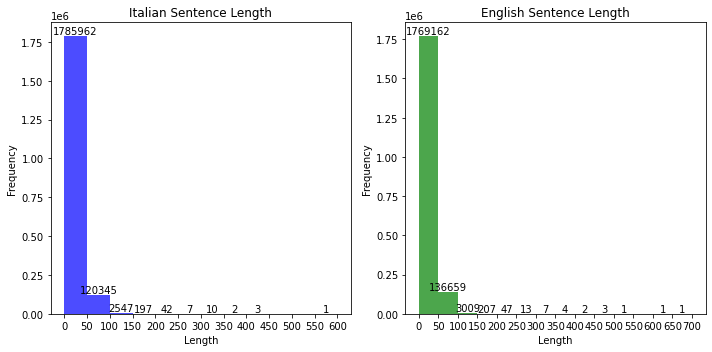

In [5]:
italian_lengths = [len(sentence.split()) for sentence in italian_sentences]
english_lengths = [len(sentence.split()) for sentence in english_sentences]

# Bins
italian_bins = np.arange(0, max(italian_lengths) + 50, 50)
english_bins = np.arange(0, max(english_lengths) + 50, 50)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(italian_lengths, bins=italian_bins, color='blue', alpha=0.7)
plt.title('Italian Sentence Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.xticks(italian_bins)

# Display frequency values
for i, freq in enumerate(np.histogram(italian_lengths, bins=italian_bins)[0]):
    if freq > 0:
        plt.text(italian_bins[i] + (italian_bins[i+1] - italian_bins[i]) / 2, 
                 freq, 
                 str(freq), 
                 ha='center', 
                 va='bottom')

plt.subplot(1, 2, 2)
plt.hist(english_lengths, bins=english_bins, color='green', alpha=0.7)
plt.title('English Sentence Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.xticks(english_bins)

for i, freq in enumerate(np.histogram(english_lengths, bins=english_bins)[0]):
    if freq > 0:
        plt.text(english_bins[i] + (english_bins[i+1] - english_bins[i]) / 2, 
                 freq, 
                 str(freq), 
                 ha='center', 
                 va='bottom')

plt.tight_layout()
plt.show()

It looks like that almost all data is shorter than 100 so it will be a good max_len size 

## Tokenize data in the DatasetDict object

In [6]:
# Use pretrained model and tokenizer
model_name = "Helsinki-NLP/opus-mt-it-en"

tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_len = 100 # from histogram

# adapted from: https://medium.com/@tskumar1320/how-to-fine-tune-pre-trained-language-translation-model-3e8a6aace9f
def preprocess(data):
    it_sentences = [sentence_pair['it'] for sentence_pair in data['translation']]
    en_sentences = [sentence_pair['en'] for sentence_pair in data['translation']]
    it_toks = tokenizer(it_sentences, padding="max_length", max_length=max_len, truncation=True)
    with tokenizer.as_target_tokenizer():
        en_toks = tokenizer(en_sentences, padding="max_length", max_length=max_len, truncation=True)
    
    it_toks["labels"] = en_toks["input_ids"]
    return it_toks

# Apply the function to all data in the dataset   
dataset_dict_tokenized = dataset_dict.map(preprocess, batched=True)

/home1/s4745000/.local/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Map:   0%|          | 0/1527292 [00:00<?, ? examples/s]

/home1/s4745000/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3935: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/190911 [00:00<?, ? examples/s]

Map:   0%|          | 0/190913 [00:00<?, ? examples/s]

<h3>The processes below were very time consuming and were run on multiple separate occasions on Hábrók servers so here only the code is provided and the results are in the report</h3>

## Hyperparam Tuning

In [7]:
def compute_metrics(pred):
    references = pred.label_ids
    predictions = pred.predictions

    # Convert token ids to text
    references = tokenizer.batch_decode(references, skip_special_tokens=True)
    predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    references = [[ref] for ref in references]
    predictions = [pred for pred in predictions]
    
    # Compute corpus BLEU score
    bleu_score = corpus_bleu(references, predictions)

    return {
        'bleu_score': bleu_score,
    }

In [8]:
BATCH_SIZE = 64
NUM_EPOCHS = 1
def hyperparam_tuning():
    lr_list = [1e-5]
    weight_decay_list = [0.1, 0.01]
    
    i = 0
    for lr in lr_list:
        for wd in weight_decay_list:
            i += 1
            print(f"{i}: lr={lr}, wd={wd}")

            args = Seq2SeqTrainingArguments(
                output_dir="results",
                evaluation_strategy = "epoch",
                learning_rate=lr,
                per_device_train_batch_size=BATCH_SIZE,
                per_device_eval_batch_size=BATCH_SIZE,
                weight_decay=wd,
                num_train_epochs=NUM_EPOCHS,
                save_strategy = "no",
                predict_with_generate=True,
                logging_dir="results"
            )

            data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

            trainer = Seq2SeqTrainer(
                model=model,
                args=args,
                train_dataset=dataset_dict_tokenized["train"],
                eval_dataset=dataset_dict_tokenized["validation"],
                tokenizer=tokenizer,
                data_collator=data_collator,
                compute_metrics=compute_metrics,
            )

            trainer.train()

In [11]:
# To run the tuning, simply uncomment the line below
# hyperparam_tuning()

We found the best hyperparameters to be learning rate: 0.00001, weight decay: 0.01

## Evaluate the baseline

In [ ]:
args = Seq2SeqTrainingArguments(
                output_dir="results",
                evaluation_strategy = "epoch",
                learning_rate=0.00001,
                per_device_train_batch_size=BATCH_SIZE,
                per_device_eval_batch_size=BATCH_SIZE,
                weight_decay=0.1,
                num_train_epochs=5,
                save_strategy = "no", # we dont want saving
                predict_with_generate=True,
                logging_dir="results"
            )

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
                model=model,
                args=args,
                train_dataset=dataset_dict_tokenized["train"],
                eval_dataset=dataset_dict_tokenized["validation"],
                tokenizer=tokenizer,
                data_collator=data_collator,
                compute_metrics=compute_metrics,
            )

test_dataset = dataset_dict_tokenized['test']

results = trainer.evaluate(test_dataset, metric_key_prefix="eval")

print("Evaluation results:", results)
# eval_bleu = 0.672

## Training

In [ ]:
# Train the model with best hyperparameters for 5 epochs and save checkpoints

args = Seq2SeqTrainingArguments(
                output_dir="results",
                evaluation_strategy = "epoch",
                learning_rate=0.00001,
                per_device_train_batch_size=BATCH_SIZE,
                per_device_eval_batch_size=BATCH_SIZE,
                weight_decay=0.1,
                num_train_epochs=4, # limited because of long training times
                save_strategy = "epoch", # save the model after every epoch
                predict_with_generate=True,
                logging_dir="results"
            )

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
                model=model,
                args=args,
                train_dataset=dataset_dict_tokenized["train"],
                eval_dataset=dataset_dict_tokenized["validation"],
                tokenizer=tokenizer,
                data_collator=data_collator,

                # compute_metrics=compute_metrics, we will compute metrics at the end

            )

trainer.train()

## Evaluate fine-tuned model

In [ ]:
# Load model from an existing checkpoint

checkpoint_path = 'path to the latest checkpoint created during training'
model = MarianMTModel.from_pretrained(checkpoint_path)

args = Seq2SeqTrainingArguments(
                output_dir="results",
                evaluation_strategy = "epoch",
                learning_rate=0.00001,
                per_device_train_batch_size=BATCH_SIZE,
                per_device_eval_batch_size=BATCH_SIZE,
                weight_decay=0.1,
                num_train_epochs=5,
                save_strategy = "no", # we dont want saving 
                predict_with_generate=True,
                logging_dir="results"
            )

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
                model=model,
                args=args,
                train_dataset=dataset_dict_tokenized["train"],
                eval_dataset=dataset_dict_tokenized["test"],
                tokenizer=tokenizer,
                compute_metrics=compute_metrics

            )

test_dataset = dataset_dict_tokenized['test']

results = trainer.evaluate(test_dataset, metric_key_prefix="eval")

print("Evaluation results:", results)
# Test BLEU: 0.673